In [5]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import warnings

warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv("../Data/Preprocessed_LCData.csv")

In [7]:
#Prepare features and target
X = df.drop(['default_flag', 'grade'], axis=1)  # default_flag omitted
y = df['grade']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [9]:
xgb_grade = XGBClassifier(
    tree_method='hist',   # CPU-friendly; can also use 'gpu_hist' or 'hist' + device='cuda' if GPU available
    device='cuda',        # enable GPU
    objective='multi:softmax',
    num_class=7,          # number of grade classes
    eval_metric='mlogloss',
    random_state=42
)

In [10]:
param_grid = {
    'n_estimators': [100, 200, 250],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

In [11]:
grid_grade = GridSearchCV(
    estimator=xgb_grade,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1
)

In [12]:
grid_grade.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


,estimator,"XGBClassifier..._class=7, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1], 'max_depth': [4, 6, ...], 'n_estimators': [100, 200, ...], 'subsample': [0.8, 1]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softmax'


In [13]:
best_xgb_grade = grid_grade.best_estimator_

In [14]:
y_pred = best_xgb_grade.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.56      0.59     62960
           1       0.47      0.57      0.51    108254
           2       0.45      0.42      0.43    108114
           3       0.64      0.59      0.62     94702

    accuracy                           0.53    374030
   macro avg       0.55      0.53      0.54    374030
weighted avg       0.53      0.53      0.53    374030

Confusion Matrix:
 [[35171 23934  3350   505]
 [15196 61187 25776  6095]
 [ 4338 33823 44928 25025]
 [ 1048 11057 26417 56180]]


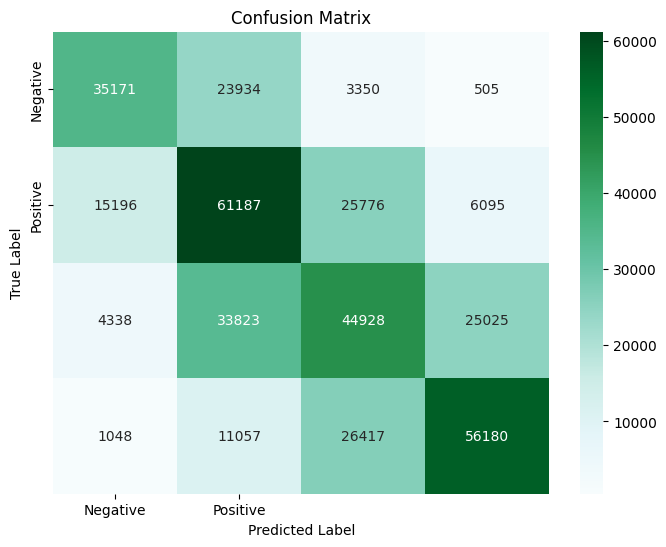

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuGn',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [16]:
joblib.dump(best_xgb_grade, 'xgb_grade_model.pkl')

['xgb_grade_model.pkl']